## Derive an RE24 matrix and LWTS from PBP data

Following the methodology described here: https://library.fangraphs.com/the-beginners-guide-to-deriving-woba/

Basic steps:

1. Compute an RE24 table by grouping all events based on starting base-out state and looking at runs scored from those situations.
2. For each PA, add the starting RE, ending RE, and the change in RE.
3. Group all of that by event type to get an average run value for each event type.
4. Store off a PA data table, which includes RE and run value fields, to use in further analysis.

Now that we have this PA table, there are all sorts of things we could do next:
* Compute wOBA weights
* Aggregate run value or RE along various dimensions (e.g., on batter or pitcher)
* Create a model to predict run value of a particular PA (e.g., based on batter and pitcher stats)

In [1]:
import pandas as pd
import numpy as np
import boxball_loader as bbl

In [2]:
YEARS = range(2000, 2021)
cols = ['game_id', 'fate_runs_ct', 'event_runs_ct', 'outs_ct', 'event_outs_ct', 'start_bases_cd', 
        'inn_ct', 'bat_home_id', 'end_bases_cd', 'game_pa_ct', 'game_end_fl', 'pit_id', 'bat_id', 
        'bat_hand_cd', 'event_cd', 'resp_pit_hand_cd', 'resp_bat_hand_cd'
]


In [3]:
ev = bbl.load_event_data(start_yr=YEARS[0], end_yr=YEARS[-1], requested_columns=cols)


In [4]:
ev.columns

Index(['game_id', 'date', 'game_type', 'pit_id', 'event_runs_ct', 'outs_ct',
       'tb_ct', 'bat_id', 'inn_ct', 'event_outs_ct', 'bat_hand_cd',
       'start_bases_cd', 'game_end_fl', 'game_pa_ct', 'end_bases_cd',
       'fate_runs_ct', 'ab_fl', 'bat_event_fl', 'event_cd', 'resp_pit_hand_cd',
       'bat_home_id', 'resp_bat_hand_cd', 'h_fl', 'ob_fl', 'yr'],
      dtype='object')

In [5]:
# Add a couple columns for computing RE24
ev['runs_finish_ct']=ev.fate_runs_ct+ev.event_runs_ct #total runs in remainder of inning
ev['end_outs_ct']=ev.outs_ct+ev.event_outs_ct # outs at end of event

In [6]:
# Choose which games we want
gms = bbl.load_gamelogs(game_types=bbl.GameType.RS, years=YEARS)

evs = ev[ev.game_id.isin(gms.game_id)]
evs.shape

(3792980, 27)

In [7]:
# Generate a basic RE24 table
re24 = evs.groupby(['start_bases_cd', 'outs_ct'])['runs_finish_ct'].mean().unstack()
re24[3] = re24[2]*0
re24 = re24.unstack()
re24

outs_ct  start_bases_cd
0        0                 0.512203
         1                 0.889792
         2                 1.136741
         3                 1.481396
         4                 1.415249
         5                 1.792460
         6                 2.003605
         7                 2.300464
1        0                 0.274082
         1                 0.532648
         2                 0.687748
         3                 0.914464
         4                 0.967363
         5                 1.178755
         6                 1.407853
         7                 1.566686
2        0                 0.105739
         1                 0.230502
         2                 0.329639
         3                 0.443857
         4                 0.359124
         5                 0.491228
         6                 0.576209
         7                 0.764310
3        0                 0.000000
         1                 0.000000
         2                 0.000000
    

In [8]:
def get_printable_re24table(re24):
    df = re24.reset_index()
    start_bases_txt = df['start_bases_cd'].apply(lambda x: ['___', '1__', '_2_', '12_', '__3', '1_3', '_23', '123'][int(x)])
    df['bases'] = start_bases_txt
    printable = df.rename(columns={0: 'run_exp', 'outs_ct': 'outs'}) \
        .set_index(['outs', 'bases']) \
        .unstack(level=0) \
        .sort_values(by=('start_bases_cd', 0))['run_exp']

    return printable.to_markdown()

print(get_printable_re24table(re24))

| bases   |        0 |        1 |        2 |   3 |
|:--------|---------:|---------:|---------:|----:|
| ___     | 0.512203 | 0.274082 | 0.105739 |   0 |
| 1__     | 0.889792 | 0.532648 | 0.230502 |   0 |
| _2_     | 1.13674  | 0.687748 | 0.329639 |   0 |
| 12_     | 1.4814   | 0.914464 | 0.443857 |   0 |
| __3     | 1.41525  | 0.967363 | 0.359124 |   0 |
| 1_3     | 1.79246  | 1.17876  | 0.491228 |   0 |
| _23     | 2.00361  | 1.40785  | 0.576209 |   0 |
| 123     | 2.30046  | 1.56669  | 0.76431  |   0 |


In [9]:
evs['score_left'] = np.where(evs['runs_finish_ct']>0, 1, 0)
evs.groupby(['start_bases_cd', 'outs_ct'])['score_left'].mean().unstack()

outs_ct,0,1,2
start_bases_cd,,,
0,0.280134,0.164672,0.071584
1,0.415944,0.267078,0.125323
2,0.618079,0.398773,0.218903
3,0.618274,0.410508,0.227956
4,0.839883,0.656401,0.248683
5,0.857428,0.639785,0.267133
6,0.853376,0.679653,0.254101
7,0.861812,0.664314,0.315213


In [10]:
gms.shape

(49486, 164)

In [65]:
half_innings = len(evs[['game_id', 'inn_ct', 'bat_home_id']].drop_duplicates())
half_innings

885547

In [12]:
# Now compute RE24 for each event
def add_REs_to_events(evs):
    # Add the re_start and re_end to each event (merge is faster than a lookup)
    e_s = pd.merge(left=evs, right=re24.rename('re_start'), on=['start_bases_cd', 'outs_ct'])
    e_e = pd.merge(left=e_s, right=re24.rename('re_end'), \
               left_on=['end_bases_cd', 'end_outs_ct'], \
               right_on=['start_bases_cd', 'outs_ct'])
    e_e['re_added'] = e_e['re_end'] - e_e['re_start'] + e_e['event_runs_ct']
    return e_e.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

In [13]:
evs_re = add_REs_to_events(evs)
evs_re.head(20)

,game_id,date,game_type,pit_id,event_runs_ct,outs_ct,tb_ct,bat_id,inn_ct,event_outs_ct,...,resp_bat_hand_cd,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added
34,ANA200004030,2000-04-03,RS,hillk001,0,0,1,knobc001,1,0,...,R,1,1,2000,0,0,0,0.512203,0.889792,0.377589
1502321,ANA200004030,2000-04-03,RS,hillk001,0,1,0,jeted001,1,1,...,R,0,0,2000,0,2,0,0.274082,0.105739,-0.168343
2365740,ANA200004030,2000-04-03,RS,hillk001,0,2,0,oneip001,1,0,...,L,0,1,2000,0,2,0,0.105739,0.230502,0.124763
3121659,ANA200004030,2000-04-03,RS,hillk001,0,2,0,willb002,1,1,...,L,0,0,2000,0,3,0,0.230502,0.000000,-0.230502
35,ANA200004030,2000-04-03,RS,herno001,0,0,1,erstd001,1,0,...,L,1,1,2000,0,0,0,0.512203,0.889792,0.377589
1475994,ANA200004030,2000-04-03,RS,herno001,0,0,0,kenna001,1,2,...,L,0,0,2000,0,2,0,0.889792,0.105739,-0.784054
2627775,ANA200004030,2000-04-03,RS,herno001,0,2,0,vaugm001,1,1,...,L,0,0,2000,0,3,0,0.105739,0.000000,-0.105739
227832,ANA200004030,2000-04-03,RS,hillk001,0,0,0,martt002,2,1,...,L,0,0,2000,0,1,0,0.512203,0.274082,-0.238121
1502322,ANA200004030,2000-04-03,RS,hillk001,0,1,0,leder001,2,1,...,L,0,0,2000,0,2,0,0.274082,0.105739,-0.168343
2365741,ANA200004030,2000-04-03,RS,hillk001,0,2,0,posaj001,2,0,...,L,0,1,2000,0,2,0,0.105739,0.230502,0.124763


In [14]:
# Just to sanity check, let's compute the sum by pitcher
evs_re.groupby('pit_id')['re_added'].sum().sort_values()

pit_id
kersc001   -511.770922
verlj001   -374.069799
schem001   -324.383404
greiz001   -322.106615
hallr001   -310.423710
               ...    
bellr003    100.327252
ortir002    101.198274
fossc001    114.619780
elars001    129.494398
limaj001    153.003707
Name: re_added, Length: 3456, dtype: float64

In [15]:
# What does total re_added sum to?
evs_re.re_added.sum()

-7980.284341778039

We might've expected the sum to come out to zero.  But it doesn't exactly, because RE24[0][0] isn't exactly equal to the the number of runs per inning.  This is because there are other [0][0] occurrences (e.g., after a leadoff HR) that are included in the re24[0][0] calculation.

In [16]:
evs_re[evs_re.game_end_fl].re_end.sum()

2880.4654508652143

In [17]:
# Now look at average RE change by event code
# This is the context-neutral run value of each event type
event_res = evs_re.groupby('event_cd').agg({'re_added': np.mean})['re_added'].rename('event_re')
event_res

event_cd
2    -0.274422
3    -0.276082
14    0.307662
15    0.169918
16    0.329926
17    0.362597
18    0.495224
19   -0.195556
20    0.453606
21    0.760431
22    1.051710
23    1.393442
Name: event_re, dtype: float64

In [18]:
event_res.to_csv('~/temp/event_res.csv')

In [19]:
# Annotate each event with the context-neutral run value of the event type
evs_re = pd.merge(left=evs_re, right=event_res, on='event_cd') \
    .sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

evs_re.head(20)

,game_id,date,game_type,pit_id,event_runs_ct,outs_ct,tb_ct,bat_id,inn_ct,event_outs_ct,...,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re
0,ANA200004030,2000-04-03,RS,hillk001,0,0,1,knobc001,1,0,...,1,1,2000,0,0,0,0.512203,0.889792,0.377589,0.453606
577635,ANA200004030,2000-04-03,RS,hillk001,0,1,0,jeted001,1,1,...,0,0,2000,0,2,0,0.274082,0.105739,-0.168343,-0.274422
2380130,ANA200004030,2000-04-03,RS,hillk001,0,2,0,oneip001,1,0,...,0,1,2000,0,2,0,0.105739,0.230502,0.124763,0.307662
577636,ANA200004030,2000-04-03,RS,hillk001,0,2,0,willb002,1,1,...,0,0,2000,0,3,0,0.230502,0.000000,-0.230502,-0.274422
1,ANA200004030,2000-04-03,RS,herno001,0,0,1,erstd001,1,0,...,1,1,2000,0,0,0,0.512203,0.889792,0.377589,0.453606
577637,ANA200004030,2000-04-03,RS,herno001,0,0,0,kenna001,1,2,...,0,0,2000,0,2,0,0.889792,0.105739,-0.784054,-0.274422
2676025,ANA200004030,2000-04-03,RS,herno001,0,2,0,vaugm001,1,1,...,0,0,2000,0,3,0,0.105739,0.000000,-0.105739,-0.276082
577638,ANA200004030,2000-04-03,RS,hillk001,0,0,0,martt002,2,1,...,0,0,2000,0,1,0,0.512203,0.274082,-0.238121,-0.274422
577639,ANA200004030,2000-04-03,RS,hillk001,0,1,0,leder001,2,1,...,0,0,2000,0,2,0,0.274082,0.105739,-0.168343,-0.274422
2380131,ANA200004030,2000-04-03,RS,hillk001,0,2,0,posaj001,2,0,...,0,1,2000,0,2,0,0.105739,0.230502,0.124763,0.307662


In [20]:
evs_re.to_parquet('~/temp/evs_re.parquet')

In [21]:
# Let's repeat the sanity check, let's compute the sum by pitcher
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('pit_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
pit_id,,
kersc001,-511.770922,-526.622092
verlj001,-374.069799,-422.375303
schem001,-324.383404,-341.927648
greiz001,-322.106615,-314.036627
hallr001,-310.423710,-320.650263
...,...,...
bellr003,100.327252,100.732158
ortir002,101.198274,117.877605
fossc001,114.619780,87.038453


In [22]:
# Now repeat for batters
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('bat_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
bat_id,,
iztuc001,-238.649149,-206.936740
escoa003,-234.528756,-220.732988
mathj001,-188.641270,-210.112536
ausmb001,-183.103342,-132.459863
gonza002,-178.063819,-145.668228
...,...,...
heltt001,588.847276,554.858225
ortid001,600.133105,537.440399
bondb001,600.916988,568.677986


In [23]:
pa = evs_re
pa.groupby('event_cd').agg({'re_added': np.mean})

,re_added
event_cd,
2,-0.274422
3,-0.276082
14,0.307662
15,0.169918
16,0.329926
17,0.362597
18,0.495224
19,-0.195556
20,0.453606


In [24]:
# We'll start simple: consider only uBB, HBP, 1B, 2B, 3B, HR; ignore IBB and Interference; everything else is an "out"

# First the positives
success_cols = [14, 16, 20, 21, 22, 23]
ignore_cols = [15, 17]
success_weights = pa[pa.event_cd.isin(success_cols)].groupby('event_cd') \
    .agg({'re_added': [len, np.mean]})['re_added'] \
    .rename(columns={'len': 'ct', 'mean': 're_added'})

success_weights

,ct,re_added
event_cd,,
14,295895.0,0.307662
16,35067.0,0.329926
20,577635.0,0.453606
21,175122.0,0.760431
22,18038.0,1.051710
23,106383.0,1.393442


In [25]:
out_weights = pa[~pa.event_cd.isin(success_cols+ignore_cols)] \
    .agg({'re_added': [len, np.mean]}) \
    .rename(columns={'re_added': 'out'}) \
    .T.rename(columns={'len': 'ct', 'mean': 're_added'})
out_weights

,ct,re_added
out,2560864.0,-0.264427


In [26]:
weights = pd.concat([success_weights, out_weights])
weights

,ct,re_added
14,295895.0,0.307662
16,35067.0,0.329926
20,577635.0,0.453606
21,175122.0,0.760431
22,18038.0,1.051710
23,106383.0,1.393442
out,2560864.0,-0.264427


In [27]:
out_value=out_weights['re_added'][0]
out_value

-0.26442718710744956

In [28]:
weights['re_over_out'] = weights.re_added-out_value
weights

,ct,re_added,re_over_out
14,295895.0,0.307662,0.572089
16,35067.0,0.329926,0.594353
20,577635.0,0.453606,0.718033
21,175122.0,0.760431,1.024858
22,18038.0,1.051710,1.316137
23,106383.0,1.393442,1.657869
out,2560864.0,-0.264427,0.000000


In [29]:
raw_woba = sum(weights['ct']*weights['re_over_out'])/sum(weights['ct'])
raw_woba

0.26120066207280995

In [30]:
sum(weights['ct']*weights['re_over_out'])

984466.340155069

In [31]:
target_woba = .315
woba_scale = target_woba/raw_woba
weights['woba_wt'] = weights['re_over_out']*woba_scale
weights, woba_scale

(            ct  re_added  re_over_out   woba_wt
 14    295895.0  0.307662     0.572089  0.689922
 16     35067.0  0.329926     0.594353  0.716771
 20    577635.0  0.453606     0.718033  0.865926
 21    175122.0  0.760431     1.024858  1.235947
 22     18038.0  1.051710     1.316137  1.587221
 23    106383.0  1.393442     1.657869  1.999340
 out  2560864.0 -0.264427     0.000000  0.000000,
 1.2059693781028527)

OK, so that gives us wOBA weights!

In [32]:
def summarize_stats(pa, groupby):
    counters_map = {'bat_event_fl': 'pa', 'ob_fl': 'ob', 'ab_fl': 'ab', 'h_fl': 'h', 'tb_ct': 'tb'}
    groups = pa.groupby(groupby)
    stats = groups[list(counters_map.keys())].sum().rename(columns=counters_map)
    stats['ba'] = stats['h']/stats['ab']
    stats['obp'] = stats['ob']/stats['pa']
    stats['slg'] = stats['tb']/stats['ab']
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['woba'] = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return stats

In [33]:
summarize_stats(pa, ['bat_hand_cd'])

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_hand_cd,,,,,,,,,
?,1,0,1,0,0.0,0.000000,0.000000,0.000000,0.000000
L,1604129,521230,1419705,370290,594635.0,0.260822,0.324930,0.418844,0.316781
R,2188850,686910,1963234,506888,812890.0,0.258190,0.313822,0.414057,0.309082


## Modeling individual PAs

### Measure outcome: run value based on event code
### Batter estimate (wOBA)
### Pitcher estimate (wOBA allowed)
### Regression or other model

In [34]:
batters = pa.groupby('bat_id')['event_re'].mean().rename('bat_re_avg')
batters

bat_id
aardd001   -0.275086
abada001   -0.123379
abadf001   -0.194452
abboj002   -0.010151
abbok002   -0.034027
              ...   
zobrb001    0.014263
zoccp001   -0.142854
zoske001   -0.274837
zulej001    0.004587
zunim001   -0.033595
Name: bat_re_avg, Length: 4674, dtype: float64

In [35]:
pitchers = pa.groupby('pit_id')['event_re'].mean().rename('pit_re_avg')
pitchers

pit_id
aardd001   -0.007503
abadf001   -0.012849
abbop001    0.011926
abrea001    0.236227
abreb002   -0.057946
              ...   
zitob001   -0.010224
zobrb001   -0.041921
zubet001   -0.001240
zumaj001   -0.030516
zycht001   -0.037368
Name: pit_re_avg, Length: 3456, dtype: float64

In [36]:
pa = pd.merge(left=pa, right=batters, on='bat_id')
pa = pd.merge(left=pa, right=pitchers, on='pit_id')

In [37]:
pa = pa.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])
pa

,game_id,date,game_type,pit_id,event_runs_ct,outs_ct,tb_ct,bat_id,inn_ct,event_outs_ct,...,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg
0,ANA200004030,2000-04-03,RS,hillk001,0,0,1,knobc001,1,0,...,2000,0,0,0,0.512203,0.889792,0.377589,0.453606,-0.015144,0.080524
3,ANA200004030,2000-04-03,RS,hillk001,0,1,0,jeted001,1,1,...,2000,0,2,0,0.274082,0.105739,-0.168343,-0.274422,0.026073,0.080524
6,ANA200004030,2000-04-03,RS,hillk001,0,2,0,oneip001,1,0,...,2000,0,2,0,0.105739,0.230502,0.124763,0.307662,0.006146,0.080524
9,ANA200004030,2000-04-03,RS,hillk001,0,2,0,willb002,1,1,...,2000,0,3,0,0.230502,0.000000,-0.230502,-0.274422,0.031730,0.080524
1214069,ANA200004030,2000-04-03,RS,herno001,0,0,1,erstd001,1,0,...,2000,0,0,0,0.512203,0.889792,0.377589,0.453606,-0.002781,-0.006243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476309,WAS202009270,2020-09-27,RS,famij001,0,2,0,turnt001,8,1,...,2020,0,3,0,0.329639,0.000000,-0.329639,-0.274422,0.031774,-0.031334
3473875,WAS202009270,2020-09-27,RS,espip001,0,0,0,nimmb001,9,1,...,2020,0,1,0,0.512203,0.274082,-0.238121,-0.274422,0.034865,0.040539
3473842,WAS202009270,2020-09-27,RS,espip001,0,1,0,davij006,9,0,...,2020,0,1,0,0.274082,0.532648,0.258566,0.307662,0.016745,0.040539
3473888,WAS202009270,2020-09-27,RS,espip001,0,1,0,alonp001,9,1,...,2020,0,2,0,0.532648,0.230502,-0.302146,-0.274422,0.050358,0.040539


In [38]:
pa['handedness'] = pa['resp_pit_hand_cd']+pa['resp_bat_hand_cd']
pa['handedness'].sample(10)

3542497    LR
2553409    RL
544375     RR
3594501    RL
1699805    RL
1747346    RL
2964937    LR
1833729    RL
798645     RR
1960485    RR
Name: handedness, dtype: object

In [39]:
import statsmodels.api as sm

In [40]:
X = pd.concat([pa[['bat_re_avg', 'pit_re_avg']], pd.get_dummies(pa['handedness'])], axis=1)
y = pa['event_re']
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     7506.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:38:37   Log-Likelihood:            -2.0944e+06
No. Observations:             3792980   AIC:                         4.189e+06
Df Residuals:                 3792973   BIC:                         4.189e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bat_re_avg     1.0067      0.006    180.128      0.000       0.996       1.018
pit_re_avg     0.9947      0.010    103.993      0.000       0.976       1.013
B?            -0.2531      0.420     -0.602      0.547      -1.077       0.571
LL            -0.0233      0.001    -29.772      0.000      -0.025      -0.022
LR             0.0124      0.000     25.207      0.000       0.011       0.013
RL             0.0080      0.000     21.855      0.000       0.007       0.009
RR            -0.0034      0.000     -9.640      0.000      -0.004      -0.003
==============================================================================
Omnibus:                   821144.304   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1498418.845
Skew:                           1.390   Prob(JB):                         0.00
Kurtosis:                       4.324   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
predictions

0          0.061478
3          0.102969
6          0.094314
9          0.120068
1214069   -0.000977
             ...   
2476309   -0.002554
3473875    0.083452
3473842    0.053807
3473888    0.087643
3473822    0.043385
Length: 3792980, dtype: float64

In [42]:
pa['re_predicted']=predictions

In [43]:
pa.groupby('bat_id')['re_predicted'].sum().sort_values()

bat_id
escoa003   -257.824564
mathj001   -223.589166
iztuc001   -159.619520
hecha001   -154.591136
molij001   -145.337678
               ...    
cabrm001    570.759952
rodra001    571.460952
berkl001    579.025287
bondb001    584.929899
pujoa001    661.021379
Name: re_predicted, Length: 4674, dtype: float64

In [44]:
pd.get_dummies(pa['handedness'])

,B?,LL,LR,RL,RR
0,0,0,0,0,1
3,0,0,0,0,1
6,0,0,0,1,0
9,0,0,0,1,0
1214069,0,0,0,1,0
...,...,...,...,...,...
2476309,0,0,0,0,1
3473875,0,0,0,1,0
3473842,0,0,0,0,1
3473888,0,0,0,0,1


In [45]:
pa.to_parquet('../data/mine/pa2015-2020.parquet')

OK, so now we can predict individual PAs.  The r^2 is very low (.013) because of the variability of PAs.  How about if we look at cohorts?

In [46]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not batters
bat_buckets = pd.qcut(pa.bat_re_avg, q=20).rename('bat_bucket')
bat_buckets

0            (-0.0152, -0.012]
3             (0.0231, 0.0289]
6            (0.00437, 0.0069]
9             (0.0289, 0.0353]
1214069    (-0.0042, -0.00104]
                  ...         
2476309       (0.0289, 0.0353]
3473875       (0.0289, 0.0353]
3473842       (0.0143, 0.0189]
3473888        (0.0472, 1.052]
3473822      (0.00437, 0.0069]
Name: bat_bucket, Length: 3792980, dtype: category
Categories (20, interval[float64]): [(-0.277, -0.0543] < (-0.0543, -0.0353] < (-0.0353, -0.0275] < (-0.0275, -0.0211] ... (0.0231, 0.0289] < (0.0289, 0.0353] < (0.0353, 0.0472] < (0.0472, 1.052]]

In [47]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not pitchers
pit_buckets = pd.qcut(pa.pit_re_avg, q=20).rename('pit_bucket')
pit_buckets

0               (0.0323, 0.851]
3               (0.0323, 0.851]
6               (0.0323, 0.851]
9               (0.0323, 0.851]
1214069    (-0.00695, -0.00483]
                   ...         
2476309       (-0.0357, -0.028]
3473875         (0.0323, 0.851]
3473842         (0.0323, 0.851]
3473888         (0.0323, 0.851]
3473822         (0.0323, 0.851]
Name: pit_bucket, Length: 3792980, dtype: category
Categories (20, interval[float64]): [(-0.277, -0.0357] < (-0.0357, -0.028] < (-0.028, -0.0231] < (-0.0231, -0.019] ... (0.0133, 0.0167] < (0.0167, 0.0217] < (0.0217, 0.0323] < (0.0323, 0.851]]

In [48]:
pa.groupby(bat_buckets)['bat_re_avg'].mean()

bat_bucket
(-0.277, -0.0543]     -0.121338
(-0.0543, -0.0353]    -0.042894
(-0.0353, -0.0275]    -0.030995
(-0.0275, -0.0211]    -0.024068
(-0.0211, -0.0152]    -0.017879
(-0.0152, -0.012]     -0.013410
(-0.012, -0.00788]    -0.010052
(-0.00788, -0.0042]   -0.005942
(-0.0042, -0.00104]   -0.002539
(-0.00104, 0.00161]    0.000501
(0.00161, 0.00437]     0.002871
(0.00437, 0.0069]      0.005754
(0.0069, 0.0105]       0.008708
(0.0105, 0.0143]       0.012364
(0.0143, 0.0189]       0.016439
(0.0189, 0.0231]       0.021012
(0.0231, 0.0289]       0.025769
(0.0289, 0.0353]       0.031517
(0.0353, 0.0472]       0.041493
(0.0472, 1.052]        0.061715
Name: bat_re_avg, dtype: float64

In [49]:
summarize_stats(pa, bat_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_bucket,,,,,,,,,
"(-0.277, -0.0543]",190844,35911,168712,27032,36481.0,0.160226,0.188169,0.216232,0.173077
"(-0.0543, -0.0353]",188552,52797,171110,39648,57045.0,0.231711,0.280013,0.333382,0.264352
"(-0.0353, -0.0275]",189636,55481,171865,41714,60956.0,0.242714,0.292566,0.354674,0.278119
"(-0.0275, -0.0211]",190021,56507,172621,43137,64174.0,0.249894,0.297372,0.371762,0.286040
"(-0.0211, -0.0152]",191503,58676,173172,43953,65724.0,0.253811,0.306397,0.379530,0.293877
"(-0.0152, -0.012]",187580,58167,170044,44048,66382.0,0.259039,0.310092,0.390381,0.299310
"(-0.012, -0.00788]",190778,59770,171359,43782,68107.0,0.255499,0.313296,0.397452,0.303829
"(-0.00788, -0.0042]",188457,59910,169517,44183,68726.0,0.260641,0.317897,0.405422,0.308861
"(-0.0042, -0.00104]",192039,61326,173440,45570,71654.0,0.262742,0.319341,0.413134,0.312401


In [50]:
summarize_stats(pa, pit_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
pit_bucket,,,,,,,,,
"(-0.277, -0.0357]",190479,51346,171692,36022,57036.0,0.209806,0.269563,0.332200,0.260310
"(-0.0357, -0.028]",189414,54631,170378,39000,61352.0,0.228903,0.288421,0.360093,0.279078
"(-0.028, -0.0231]",191160,56340,172460,41472,64218.0,0.240473,0.294727,0.372365,0.285636
"(-0.0231, -0.019]",187748,55864,167971,40228,64219.0,0.239494,0.297548,0.382322,0.290441
"(-0.019, -0.0154]",192109,58317,172287,42111,66586.0,0.244424,0.303562,0.386483,0.295312
"(-0.0154, -0.0122]",187453,57412,168081,41569,66047.0,0.247315,0.306274,0.392947,0.298801
"(-0.0122, -0.00905]",190663,59214,169907,42413,67212.0,0.249625,0.310569,0.395581,0.301736
"(-0.00905, -0.00695]",191095,59798,171434,43919,69360.0,0.256186,0.312923,0.404587,0.305703
"(-0.00695, -0.00483]",186871,58893,166824,42517,68118.0,0.254861,0.315153,0.408323,0.308330


In [51]:
bucketed = pa.groupby([bat_buckets, pit_buckets])[['bat_re_avg', 'pit_re_avg', 'event_re']].mean()
bucketed

bat_re_avg  pit_re_avg  event_re
bat_bucket        pit_bucket                                         
(-0.277, -0.0543] (-0.277, -0.0357]   -0.107384   -0.047419 -0.139732
                  (-0.0357, -0.028]   -0.115629   -0.031044 -0.132922
                  (-0.028, -0.0231]   -0.118315   -0.025086 -0.136825
                  (-0.0231, -0.019]   -0.121120   -0.021102 -0.135687
                  (-0.019, -0.0154]   -0.118987   -0.017105 -0.128858
...                                         ...         ...       ...
(0.0472, 1.052]   (0.0104, 0.0133]     0.062016    0.011705  0.080983
                  (0.0133, 0.0167]     0.062184    0.014915  0.079496
                  (0.0167, 0.0217]     0.062700    0.019143  0.095111
                  (0.0217, 0.0323]     0.062155    0.026564  0.094341
                  (0.0323, 0.851]      0.062519    0.051299  0.119202

[400 rows x 3 columns]

In [52]:
X = bucketed[['bat_re_avg', 'pit_re_avg']]
y = bucketed['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.322e+04
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:38:43   Log-Likelihood:                 1540.1
No. Observations:                 400   AIC:                            -3074.
Df Residuals:                     397   BIC:                            -3062.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      7.823      0.000       0.002       0.003
bat_re_avg     0.9932      0.007    140.576      0.000       0.979       1.007
pit_re_avg     0.9938      0.012     82.331      0.000       0.970       1.017
==============================================================================
Omnibus:                       27.581   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.078
Skew:                          -0.421   Prob(JB):                     8.10e-12
Kurtosis:                       4.534   Cond. No.                         46.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great!  This gives basically the same prediction model as when we went PA-by-PA (very similar coefficients), but now with an r^2 of .96.  I think this shows that the model is good, but the PA-by-PA evaluation is necessarily going to show low r^2 due to variation.

In [53]:
model

### Umpires

In [54]:
gms.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [55]:
gms[['game_id', 'umpire_h_id']]

,game_id,umpire_h_id
9728,NYN200003290,marsr901
9729,CHN200003300,herna901
9732,FLO200004030,demud901
9739,OAK200004030,monte901
9738,MIN200004030,reedr901
...,...,...
161558,NYA202009270,buckc901
161560,TBA202009270,rackd901
161562,TOR202009270,bacoj901
161561,TEX202009270,hudsm901


In [56]:
pa_w_ump = pd.merge(left=pa, right=gms[['game_id', 'umpire_h_id']], on='game_id')
pa_w_ump

,game_id,date,game_type,pit_id,event_runs_ct,outs_ct,tb_ct,bat_id,inn_ct,event_outs_ct,...,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg,handedness,re_predicted,umpire_h_id
0,ANA200004030,2000-04-03,RS,hillk001,0,0,1,knobc001,1,0,...,0,0.512203,0.889792,0.377589,0.453606,-0.015144,0.080524,RR,0.061478,mcclt901
1,ANA200004030,2000-04-03,RS,hillk001,0,1,0,jeted001,1,1,...,0,0.274082,0.105739,-0.168343,-0.274422,0.026073,0.080524,RR,0.102969,mcclt901
2,ANA200004030,2000-04-03,RS,hillk001,0,2,0,oneip001,1,0,...,0,0.105739,0.230502,0.124763,0.307662,0.006146,0.080524,RL,0.094314,mcclt901
3,ANA200004030,2000-04-03,RS,hillk001,0,2,0,willb002,1,1,...,0,0.230502,0.000000,-0.230502,-0.274422,0.031730,0.080524,RL,0.120068,mcclt901
4,ANA200004030,2000-04-03,RS,herno001,0,0,1,erstd001,1,0,...,0,0.512203,0.889792,0.377589,0.453606,-0.002781,-0.006243,RL,-0.000977,mcclt901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792975,WAS202009270,2020-09-27,RS,famij001,0,2,0,turnt001,8,1,...,0,0.329639,0.000000,-0.329639,-0.274422,0.031774,-0.031334,RR,-0.002554,valej901
3792976,WAS202009270,2020-09-27,RS,espip001,0,0,0,nimmb001,9,1,...,0,0.512203,0.274082,-0.238121,-0.274422,0.034865,0.040539,RL,0.083452,valej901
3792977,WAS202009270,2020-09-27,RS,espip001,0,1,0,davij006,9,0,...,0,0.274082,0.532648,0.258566,0.307662,0.016745,0.040539,RR,0.053807,valej901
3792978,WAS202009270,2020-09-27,RS,espip001,0,1,0,alonp001,9,1,...,0,0.532648,0.230502,-0.302146,-0.274422,0.050358,0.040539,RR,0.087643,valej901


In [57]:
summarize_stats(pa_w_ump, 'umpire_h_id')

,pa,ob,ab,h,tb,ba,obp,slg,woba
umpire_h_id,,,,,,,,,
addir901,4088,1265,3646,895,1549,0.245474,0.309442,0.424849,0.311451
armer901,910,282,817,208,323,0.254590,0.309890,0.395349,0.300873
arrid901,216,80,192,58,106,0.302083,0.370370,0.552083,0.385185
aschd901,615,202,547,150,242,0.274223,0.328455,0.442413,0.324950
bacce901,468,135,416,88,158,0.211538,0.288462,0.379808,0.287927
...,...,...,...,...,...,...,...,...,...
wintm901,47622,15251,42486,11096,17627,0.261168,0.320251,0.414890,0.312839
wolcq901,15133,4834,13568,3527,5685,0.259950,0.319434,0.419001,0.314296
wolfj901,46483,14846,41594,10934,17474,0.262874,0.319386,0.420109,0.313903


In [58]:
ump_stats = pa_w_ump.groupby('umpire_h_id').agg({'bat_event_fl': len, 're_predicted': np.mean , 'event_re': np.mean}).rename(columns={'bat_event_fl': 'pa'})
ump_stats

,pa,re_predicted,event_re
umpire_h_id,,,
addir901,4088,-0.004960,-0.003840
armer901,910,-0.000035,-0.011268
arrid901,216,0.015304,0.064088
aschd901,615,0.002657,0.009888
bacce901,468,-0.009026,-0.027316
...,...,...,...
wintm901,47622,-0.001092,-0.001551
wolcq901,15133,-0.009440,-0.001561
wolfj901,46483,-0.001763,-0.000639


<AxesSubplot:xlabel='re_predicted', ylabel='event_re'>

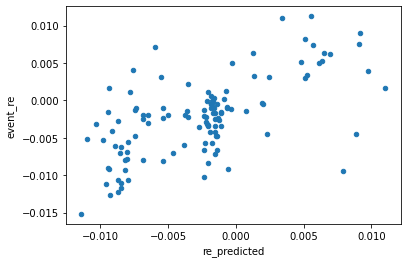

In [59]:
ump_stats.loc[ump_stats['pa']>6000].plot.scatter(x='re_predicted', y='event_re')

<AxesSubplot:xlabel='umpire_h_id'>

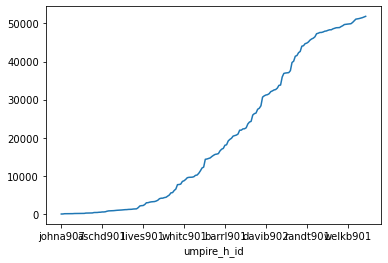

In [60]:
ump_stats.sort_values(by='pa').pa.plot()

In [61]:
ump_stats['re_effect_obs'] = ump_stats['event_re']-ump_stats['re_predicted']
ump_stats.sort_values(by='pa')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
johna907,77,-0.019435,-0.001248,0.018186
willl901,87,0.019042,0.101876,0.082834
willr901,153,0.017453,-0.002671,-0.020124
merzd901,153,-0.005945,-0.019687,-0.013742
riggj901,156,-0.001344,-0.048003,-0.046660
...,...,...,...,...
hudsm901,51259,-0.001702,-0.001700,0.000002
timmt901,51372,-0.001603,0.000268,0.001870
herna901,51497,-0.001926,-0.004273,-0.002347


<AxesSubplot:>

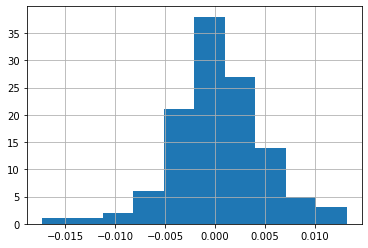

In [62]:
ump_stats.loc[ump_stats['pa']>6000].re_effect_obs.hist()

In [63]:
ump_stats.loc[ump_stats['pa']>6000].sort_values(by='re_effect_obs')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
hirsm901,7803,0.007868,-0.009460,-0.017328
craft901,11378,0.008834,-0.004485,-0.013319
shulj901,6611,0.011027,0.001649,-0.009379
hirsj901,31015,-0.000556,-0.009217,-0.008661
eddid901,50671,-0.002387,-0.010267,-0.007880
...,...,...,...,...
dejer901,7762,-0.005503,0.003111,0.008614
lentn901,9722,-0.007842,0.001089,0.008931
rackd901,16610,-0.009384,0.001714,0.011098
